In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [15]:
df = pd.read_csv("data/processed/happiness_model.csv")  

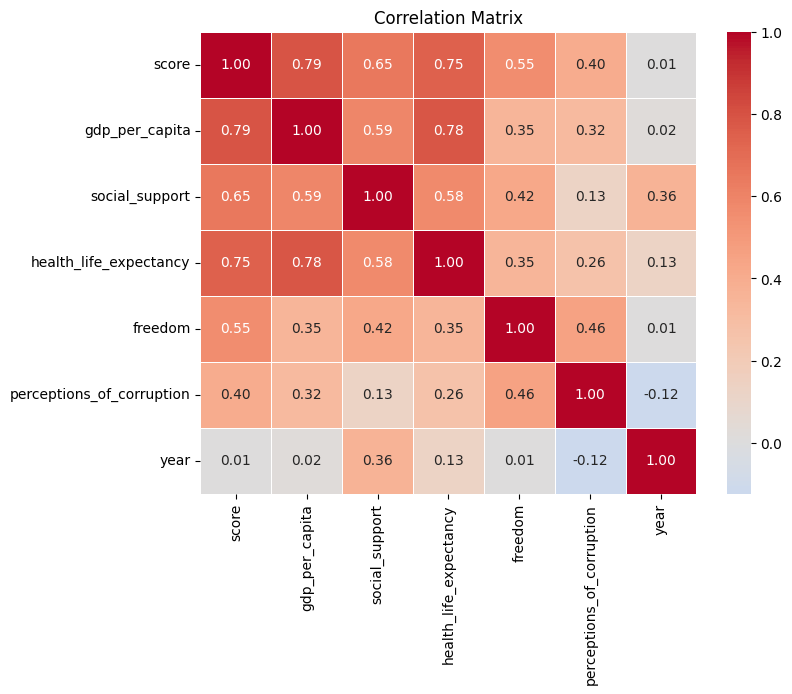

In [16]:
plt.figure(figsize=(8,6))
corr_matrix = df[[
    "score",
    "gdp_per_capita",
    "social_support",
    "health_life_expectancy",
    "freedom",
    "perceptions_of_corruption",
    "year"
]].corr()

sns.heatmap(
    corr_matrix, annot=True, cmap='coolwarm', center=0,
    linewidths=0.5, fmt=".2f"
)
plt.title("Correlation Matrix")
plt.show()


In [4]:
X = df[[
    "gdp_per_capita",
    "social_support",
    "health_life_expectancy",
    "freedom",
    "perceptions_of_corruption",
    "year"
]]
y = df["score"]

print(f"Observaciones totales: {len(df)}")

Observaciones totales: 771


In [5]:
X_ols = sm.add_constant(X)
modelo = sm.OLS(y, X_ols).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     429.0
Date:                Thu, 06 Nov 2025   Prob (F-statistic):          1.03e-240
Time:                        20:59:54   Log-Likelihood:                -622.74
No. Observations:                 771   AIC:                             1259.
Df Residuals:                     764   BIC:                             1292.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

### Supuestos

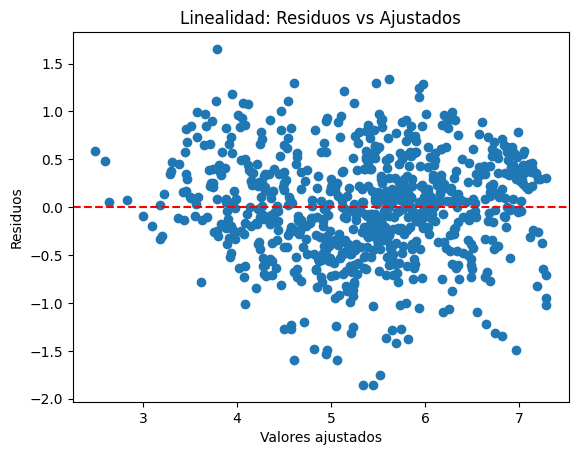

In [6]:
plt.scatter(modelo.fittedvalues, modelo.resid)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Linealidad: Residuos vs Ajustados")
plt.show()

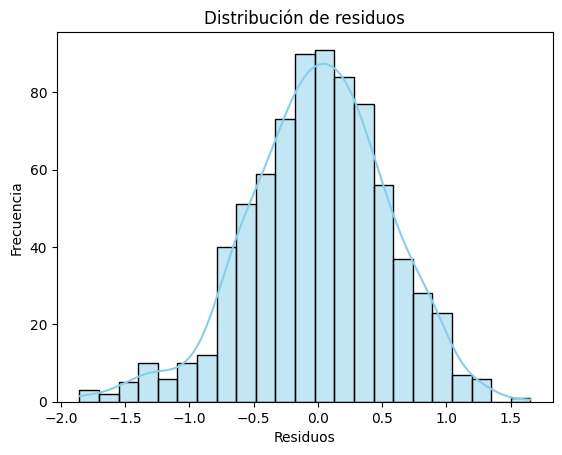

In [7]:
sns.histplot(modelo.resid, kde=True, color='skyblue')
plt.title("Distribución de residuos")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.show()

In [8]:
shapiro_test = stats.shapiro(modelo.resid)
ad_test = normal_ad(modelo.resid)
print(f"Shapiro-Wilk: p={shapiro_test.pvalue:.4f}")
print(f"Anderson-Darling: p={ad_test[1]:.4f}")

Shapiro-Wilk: p=0.0010
Anderson-Darling: p=0.0327


In [9]:
vif = pd.DataFrame()
vif["Variable"] = X_ols.columns
vif["VIF"] = [variance_inflation_factor(X_ols.values, i) for i in range(X_ols.shape[1])]
print(vif)

                    Variable           VIF
0                      const  2.593879e+06
1             gdp_per_capita  3.095571e+00
2             social_support  2.207664e+00
3     health_life_expectancy  2.780841e+00
4                    freedom  1.548921e+00
5  perceptions_of_corruption  1.381830e+00
6                       year  1.281826e+00


### Model training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
n, k = X_test.shape

results = []

def model_eval(nombre, y_test, y_pred, n, k):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    aic = n * np.log(mse) + 2 * (k + 1)
    bic = n * np.log(mse) + (k + 1) * np.log(n)
    return [nombre, r2, rmse, mape, aic, bic]

ols = LinearRegression().fit(X_train, y_train)
y_pred_ols = ols.predict(X_test)
results.append(model_eval("OLS", y_test, y_pred_ols, n, k))

ridge = RidgeCV(alphas=np.arange(0.01, 1, 0.05), cv=5).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
results.append(model_eval("Ridge", y_test, y_pred_ridge, n, k))

lasso = LassoCV(alphas=np.arange(0.001, 1, 0.01), cv=5, n_jobs=-1, random_state=42).fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
results.append(model_eval("Lasso", y_test, y_pred_lasso, n, k))

elastic = ElasticNetCV(alphas=np.arange(0.001, 1, 0.01),
                       l1_ratio=np.arange(0.1, 1, 0.1),
                       cv=5, n_jobs=-1, random_state=42).fit(X_train, y_train)
y_pred_elastic = elastic.predict(X_test)
results.append(model_eval("ElasticNet", y_test, y_pred_elastic, n, k))

df_results = pd.DataFrame(results, columns=["Modelo", "R²", "RMSE", "MAPE", "AIC", "BIC"])
df_results = df_results.round(4).sort_values("R²", ascending=False).reset_index(drop=True)
display(df_results)

,Modelo,R²,RMSE,MAPE,AIC,BIC
0,Ridge,0.7735,0.5431,0.0856,-269.2850,-245.1579
1,OLS,0.7734,0.5432,0.0854,-269.1764,-245.0492
2,ElasticNet,0.7734,0.5431,0.0856,-269.2372,-245.1100
3,Lasso,0.7727,0.5440,0.0856,-268.4662,-244.3390


In [ ]:
best_model_name = df_results.loc[df_results["R²"].idxmax(), "Modelo"]
print(f"Mejor modelo: {best_model_name}")

if best_model_name == "OLS":
    best_model = ols
elif best_model_name == "Ridge":
    best_model = ridge
elif best_model_name == "Lasso":
    best_model = lasso
else:
    best_model = elastic

joblib.dump(best_model, f"models/Best_{best_model_name}_Model.pkl")
print(f"Modelo guardado como: Best_{best_model_name}_Model.pkl")

 Mejor modelo: Ridge
Modelo guardado como: Best_Ridge_Model.pkl


In [ ]:
df_all = df.copy()

df_all["score_predicho"] = np.nan
df_all["is_train"] = 0
df_all["is_test"] = 0

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

df_all["score_real"] = df["score"]

df_all.loc[X_train.index, "score_predicho"] = y_pred_train
df_all.loc[X_test.index, "score_predicho"] = y_pred_test

df_all.loc[X_train.index, "is_train"] = 1
df_all.loc[X_test.index, "is_test"] = 1

cols = [
    "gdp_per_capita", "social_support", "health_life_expectancy",
    "freedom", "perceptions_of_corruption", "year",
    "score_real", "score_predicho", "is_train", "is_test"
]
df_all = df_all[cols]

csv_path = f"data/processed/happiness_predictions_{best_model_name}.csv"
df_all.to_csv(csv_path, index=False)

print(f"Archivo completo guardado: {csv_path}")
print(f"Filas totales: {len(df_all)}")
display(df_all.head())


Archivo completo guardado: data/processed/happiness_predictions_Ridge.csv
Filas totales: 771


,gdp_per_capita,social_support,health_life_expectancy,freedom,perceptions_of_corruption,year,score_real,score_predicho,is_train,is_test
0,1.39651,1.34951,0.94143,0.66557,0.41978,2015,7.587,7.238844,1,0
1,1.30232,1.40223,0.94784,0.62877,0.14145,2015,7.561,6.950651,1,0
2,1.32548,1.36058,0.87464,0.64938,0.48357,2015,7.527,7.117648,0,1
3,1.45900,1.33095,0.88521,0.66973,0.36503,2015,7.522,7.199307,1,0
4,1.32629,1.32261,0.90563,0.63297,0.32957,2015,7.427,6.996198,1,0


In [ ]:
y_pred_final = best_model.predict(X)
mse = mean_squared_error(y, y_pred_final)
r2 = r2_score(y, y_pred_final)
print(f"Modelo final: {best_model_name} — R²={r2:.4f} | RMSE={np.sqrt(mse):.4f}")

Modelo final: Ridge — R²=0.7704 | RMSE=0.5435
